## Imports

In [5]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Load

In [2]:
df = pd.read_csv('data/400_m_hurdles_v7.csv')
df.head()


,name,competition,heat,date,total_time,lane,place,reaction_time,total_strides,hurdle_id,hurdle_timing,interval,velocity,strides,event,W/M,temporary_place,race_id,hurdle_id_label,cluster_id
0,"Abt, Gudrun","1988 Olympic Games (Seoul, KOR)",FINAL,1988-09-28,54.04,8.0,6,0.316,179.0,1,6.53,6.53,6.89,23.0,400m_H,W,4.0,1988_OG_FINAL,[start-H1],1
1,"Abt, Gudrun","1988 Olympic Games (Seoul, KOR)",FINAL,1988-09-28,54.04,8.0,6,0.316,179.0,2,10.69,4.16,8.41,15.0,400m_H,W,5.0,1988_OG_FINAL,[H1-H2],1
2,"Abt, Gudrun","1988 Olympic Games (Seoul, KOR)",FINAL,1988-09-28,54.04,8.0,6,0.316,179.0,3,14.98,4.29,8.16,15.0,400m_H,W,5.0,1988_OG_FINAL,[H2-H3],1
3,"Abt, Gudrun","1988 Olympic Games (Seoul, KOR)",FINAL,1988-09-28,54.04,8.0,6,0.316,179.0,4,19.30,4.32,8.10,15.0,400m_H,W,5.0,1988_OG_FINAL,[H3-H4],1
4,"Abt, Gudrun","1988 Olympic Games (Seoul, KOR)",FINAL,1988-09-28,54.04,8.0,6,0.316,179.0,5,23.82,4.52,7.74,15.0,400m_H,W,5.0,1988_OG_FINAL,[H4-H5],1


In [3]:
df.total_time.describe()

count    8074.000000
mean       56.871444
std         3.182927
min        51.450000
25%        54.330000
50%        55.695000
75%        59.600000
max        74.880000
Name: total_time, dtype: float64

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8074 entries, 0 to 8073
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             8074 non-null   object 
 1   competition      8074 non-null   object 
 2   heat             8074 non-null   object 
 3   date             8074 non-null   object 
 4   total_time       8074 non-null   float64
 5   lane             8074 non-null   float64
 6   place            8074 non-null   int64  
 7   reaction_time    8074 non-null   object 
 8   total_strides    8074 non-null   float64
 9   hurdle_id        8074 non-null   int64  
 10  hurdle_timing    8074 non-null   float64
 11  interval         8074 non-null   float64
 12  velocity         8074 non-null   float64
 13  strides          8074 non-null   float64
 14  event            8074 non-null   object 
 15  W/M              8074 non-null   object 
 16  temporary_place  8074 non-null   float64
 17  race_id       

## Clean

In [5]:
df_original = pd.read_csv('data/400_m_hurdles_v7.csv')
df = df_original.copy()
df.rename(columns={'name':'athlete', 'race_id':'race'}, inplace=True)
pd.to_datetime(df['date'], format='%Y-%m-%d')
#df['race'] = df['competition'].str.split('(').str[0].str.split().apply(lambda x: x[0] + '-' + ''.join(word[0] for word in x[1:]))+'-'+df['heat']
df['split'] = df['hurdle_id'].astype('str')

# Find PB
df['total_time'] = df.groupby(['athlete', 'race'])['hurdle_timing'].transform('max')
pb = df.groupby(['athlete'])['total_time'].transform('min') == df['total_time']
df['is_pb'] = pb

# Find stride diff
df['stride_diff'] = df.groupby(['athlete', 'race'])['strides'].transform('min')
df['stride_diff'] = df['strides'] - df['stride_diff']

## Remove outliers

In [6]:
# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = df['total_time'].quantile(0.25)
Q3 = df['total_time'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude outliers
df_filt = df[(df['total_time'] >= lower_bound) & (df['total_time'] <= upper_bound)].copy().reset_index()

## Create clusters

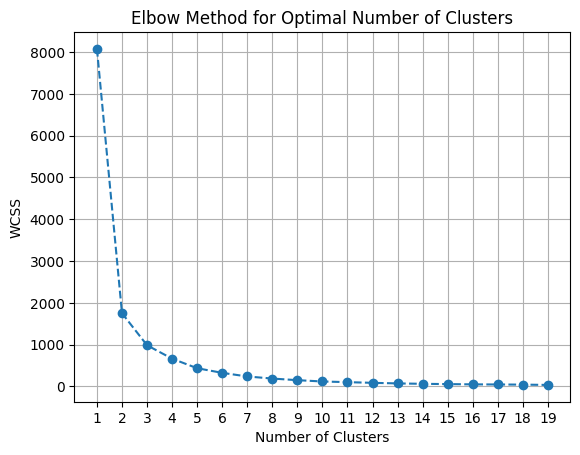

In [7]:
# Extract the column for clustering
X = df_filt[['total_time']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, 20), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, 20))
plt.grid(True)
plt.show()

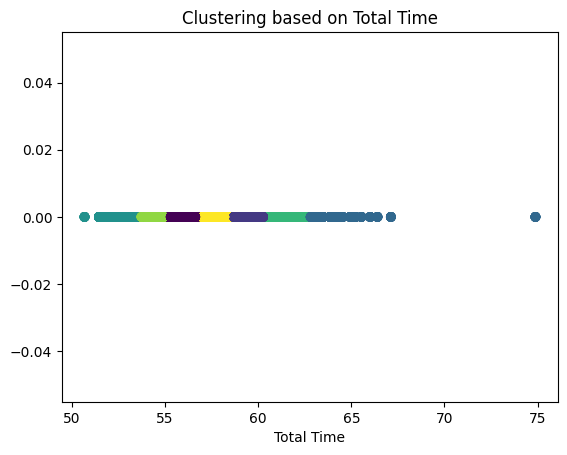

In [8]:
# Extract the column for clustering
X = df_filt[['total_time']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit_predict(X_scaled)
df['cluster'] = kmeans.predict(scaler.transform(df[['total_time']]))
df_filt['cluster'] = kmeans.predict(X_scaled)

# Visualize the clusters
plt.scatter(df['total_time'], [0] * len(df), c=df['cluster'], cmap='viridis')
plt.xlabel('Total Time')
plt.title('Clustering based on Total Time')
plt.show()

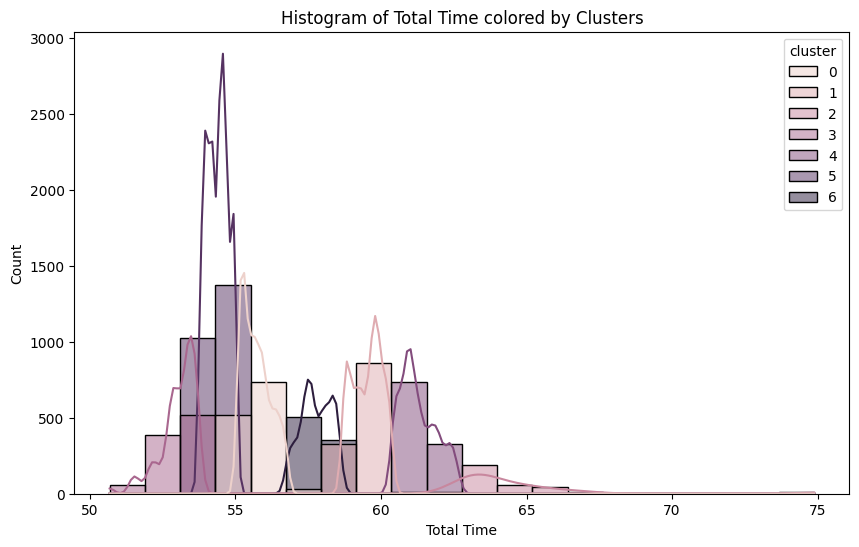

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='total_time', hue='cluster', bins=20, kde=True)
plt.title('Histogram of Total Time colored by Clusters')
plt.xlabel('Total Time')
plt.ylabel('Count')
plt.show()

In [10]:
cluster_dict = {}
for cluster, centroid in enumerate(scaler.inverse_transform(kmeans.cluster_centers_)):
    cluster_dict[cluster] = centroid[0]
cluster_dict

{0: 55.74818965517241,
 1: 59.53449541284404,
 2: 64.015,
 3: 53.068461538461534,
 4: 61.28979381443298,
 5: 54.40875,
 6: 57.776363636363634}

In [11]:
df['cluster_centroid'] = df['cluster']
df['cluster_centroid'] = df['cluster_centroid'].map(cluster_dict)

In [12]:
df_filt['cluster_centroid'] = df_filt['cluster']
df_filt['cluster_centroid'] = df_filt['cluster_centroid'].map(cluster_dict)

In [13]:
for cluster in df.cluster.unique():
    print(df[df['cluster']==cluster]['total_time'].describe())

count    2398.000000
mean       54.390321
std         0.364030
min        53.740000
25%        54.090000
50%        54.420000
75%        54.670000
max        55.060000
Name: total_time, dtype: float64
count    957.000000
mean      53.037471
std        0.606957
min       50.680000
25%       52.790000
50%       53.220000
75%       53.480000
max       53.720000
Name: total_time, dtype: float64
count    1287.000000
mean       55.728120
std         0.478096
min        55.080000
25%        55.290000
50%        55.650000
75%        56.070000
max        56.760000
Name: total_time, dtype: float64
count    1199.000000
mean       59.534495
std         0.496994
min        58.670000
25%        59.070000
50%        59.620000
75%        59.890000
max        60.370000
Name: total_time, dtype: float64
count    858.000000
mean      57.763462
std        0.513547
min       56.770000
25%       57.400000
50%       57.745000
75%       58.210000
max       58.650000
Name: total_time, dtype: float64
count    31

<Axes: xlabel='cluster_centroid', ylabel='total_time'>

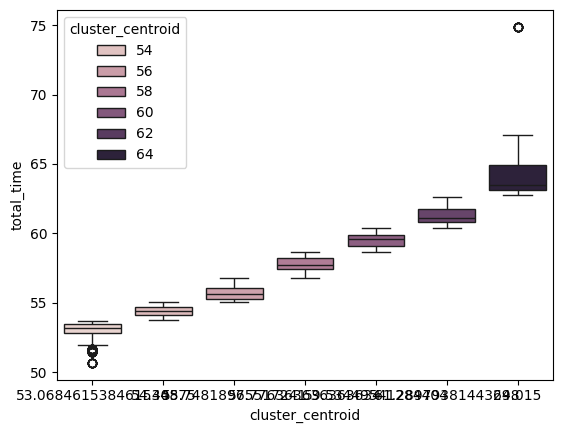

In [14]:
sns.boxplot(x="cluster_centroid", y="total_time",
            hue="cluster_centroid",
            data=df)

## Compute splits statistics within cluster

In [16]:

# Group by 'cluster' and 'split', then compute statistics
stats = df_filt.groupby(['cluster', 'split'])['interval'].agg(['mean', 'median', 'std', 'quantile'])

# Rename columns
stats.columns = ['mean_intervals', 'median_intervals', 'std_intervals', 'quantile_intervals']

# Merge statistics back to the original DataFrame
df = pd.merge(df, stats, left_on=['cluster', 'split'], right_on=['cluster', 'split'], how='left')
df.head()

,athlete,competition,heat,date,total_time,lane,place,reaction_time,total_strides,hurdle_id,...,cluster_id,split,is_pb,stride_diff,cluster,cluster_centroid,mean_intervals,median_intervals,std_intervals,quantile_intervals
0,"Abt, Gudrun","1988 Olympic Games (Seoul, KOR)",FINAL,1988-09-28,54.04,8.0,6,0.316,179.0,1,...,1,1,True,8.0,5,54.40875,6.365734,6.360,0.161778,6.360
1,"Abt, Gudrun","1988 Olympic Games (Seoul, KOR)",FINAL,1988-09-28,54.04,8.0,6,0.316,179.0,2,...,1,2,True,0.0,5,54.40875,4.160413,4.160,0.124369,4.160
2,"Abt, Gudrun","1988 Olympic Games (Seoul, KOR)",FINAL,1988-09-28,54.04,8.0,6,0.316,179.0,3,...,1,3,True,0.0,5,54.40875,4.273807,4.280,0.130326,4.280
3,"Abt, Gudrun","1988 Olympic Games (Seoul, KOR)",FINAL,1988-09-28,54.04,8.0,6,0.316,179.0,4,...,1,4,True,0.0,5,54.40875,4.361743,4.360,0.106220,4.360
4,"Abt, Gudrun","1988 Olympic Games (Seoul, KOR)",FINAL,1988-09-28,54.04,8.0,6,0.316,179.0,5,...,1,5,True,0.0,5,54.40875,4.495550,4.495,0.105008,4.495


In [17]:
stats

mean_intervals  median_intervals  std_intervals  \
cluster split                                                    
0       1            6.448205             6.450       0.153716   
        10           5.490342             5.410       0.295054   
        11           6.852308             6.280       1.937676   
        2            4.248034             4.240       0.103983   
        3            4.358120             4.360       0.094120   
...                       ...               ...            ...   
6       5            4.806154             4.820       0.107004   
        6            4.971282             4.975       0.107816   
        7            5.115769             5.115       0.109206   
        8            5.256795             5.260       0.110189   
        9            5.444231             5.430       0.120986   

               quantile_intervals  
cluster split                      
0       1                   6.450  
        10                  5.410  
        11                  6.280  
        2                   4.240  
        3                   4.360  
...                           ...  
6       5                   4.820  
        6                   4.975  
        7                   5.115  
        8                   5.260  
        9                   5.430  

[77 rows x 4 columns]

## Compute feature importance within clusters

In [34]:
df_pivot = df.pivot(index=['athlete', 'competition', 'heat', 'race', 'total_time', 'cluster'], columns='split', values='interval',).reset_index()

df_pivot

split,athlete,competition,heat,race,total_time,cluster,1,10,11,2,3,4,5,6,7,8,9
0,"Abt, Gudrun","1988 Olympic Games (Seoul, KOR)",FINAL,1988_OG_FINAL,54.04,5,6.53,5.24,5.76,4.16,4.29,4.32,4.52,4.61,4.68,4.84,5.09
1,"Abt, Gudrun","1988 Olympic Games (Seoul, KOR)",Semi-Final 2,1988_OG_Semi-Final 2,54.52,5,6.51,5.30,5.82,4.16,4.27,4.36,4.46,4.69,4.82,5.03,5.10
2,"Adekoya, Kemi","2016 Birmingham Diamond League (Birmingham, GBR)",FINAL,2016_DL_GBR_FINAL,55.28,0,6.43,5.30,6.01,4.20,4.37,4.37,4.50,4.80,4.90,5.13,5.27
3,"Adekoya, Kemi","2016 Doha Diamond League (Doha, QAT)",FINAL,2016_DL_QAT_FINAL,54.87,5,6.52,5.28,5.71,4.32,4.32,4.40,4.56,4.64,4.80,5.08,5.24
4,"Adekoya, Kemi",2016 Meeting International Mohammed VI D'Athle...,FINAL,2016_DL_MAR_FINAL,55.33,0,6.40,5.36,6.05,4.36,4.36,4.44,4.48,4.68,4.88,5.12,5.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,Zou Yifan,"2021 East China District Meeting (Zhaoqing, CHN)",FINAL,2021_NGP_CHN_FINAL,57.78,6,6.74,5.44,6.01,4.52,4.59,4.72,4.90,5.09,5.23,5.23,5.31
731,Zou Yifan,"2021 East China District Meeting (Zhaoqing, CHN)",Heat 1,2021_NGP_CHN_Heat 1,57.63,6,6.76,5.62,6.20,4.45,4.51,4.60,4.77,4.92,5.07,5.18,5.55
732,Zou Yifan,2021 Philippe Cup Athletics Invitational (Wuha...,FINAL,2021_CT_CHN_FINAL,57.62,6,6.81,5.59,6.30,4.40,4.55,4.61,4.80,4.89,5.09,5.24,5.34
733,"van der Walt, Zenéy","2018 IAAF World Junior Championships (Tampere,...",FINAL,2018_WJCH_FINAL,55.34,0,6.50,5.36,6.18,4.16,4.37,4.37,4.56,4.70,4.87,5.13,5.14


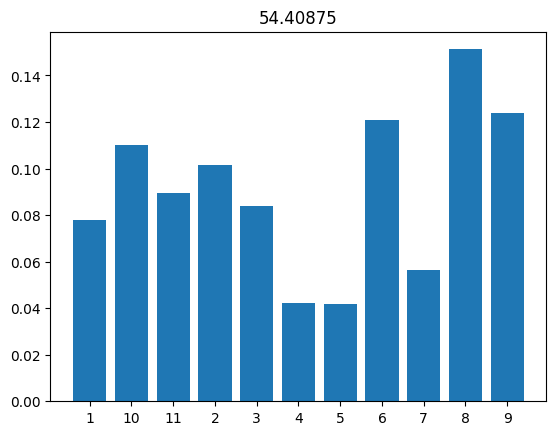

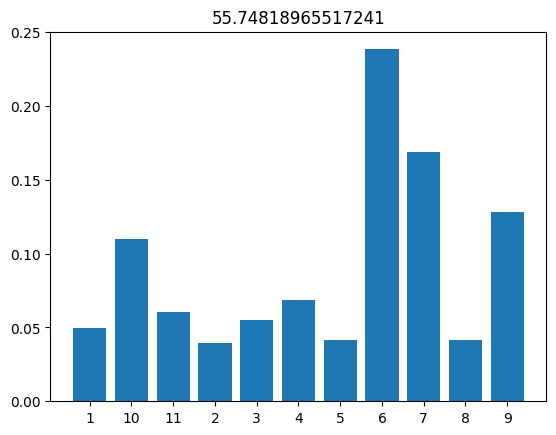

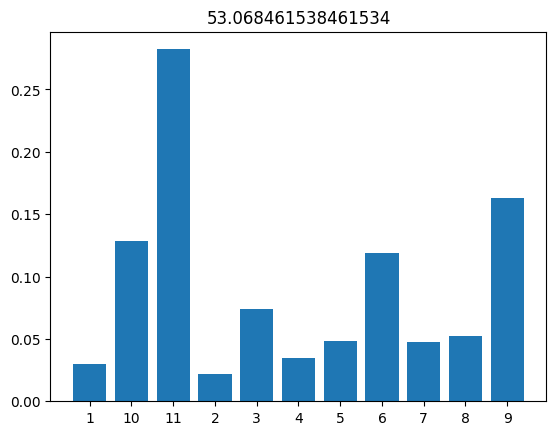

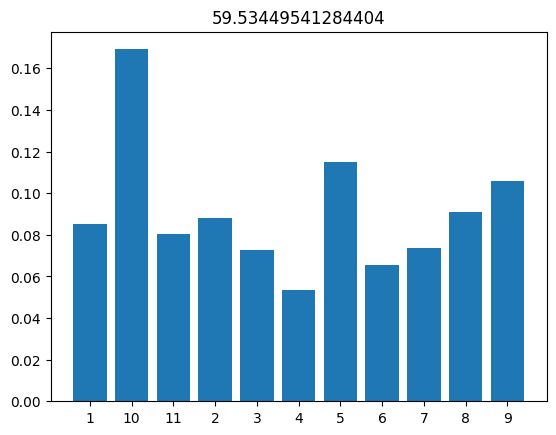

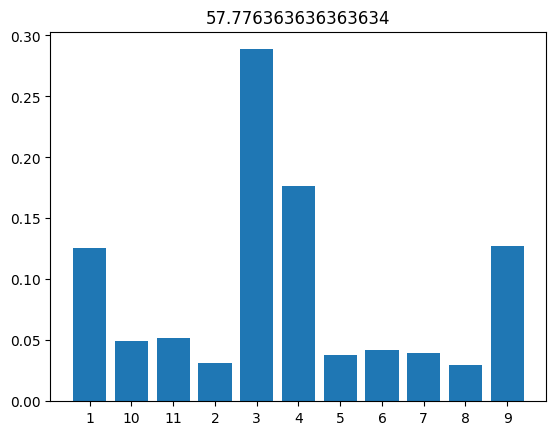

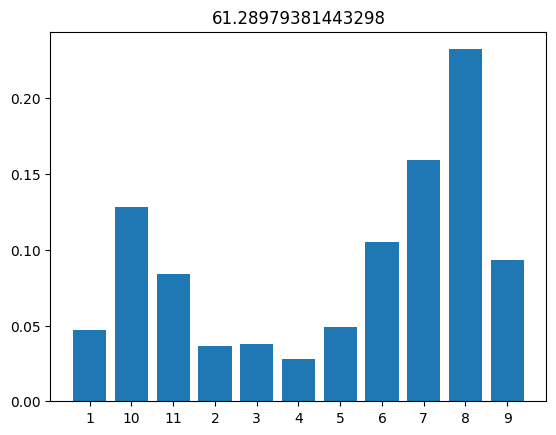

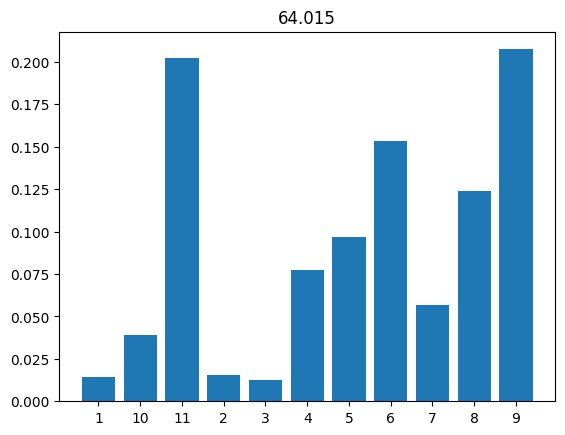

In [63]:

# Separate data into X (features) and y (target)
from sklearn.ensemble import RandomForestRegressor

feature_importances_clusters=[]
for cluster in df_pivot.cluster.unique():
    df_feat = df_pivot[df_pivot['cluster']==cluster]
    X = df_feat.drop(columns=['athlete','competition','heat', 'race', 'total_time','cluster' ]) # Features excluding 'total_time' and 'split'
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y = df_feat['total_time']  # Target variable

    # Initialize and fit the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_scaled, y)

    # Get feature importances
    feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

    for split, feature in enumerate(feature_importances):
        feature_importances_clusters.append({
            'cluster':cluster,
            'split':split,
            'feature_importance':feature
        })

In [58]:
df_importances_rf = pd.DataFrame(feature_importances_clusters, )
df_importances_rf['split']=df_importances_rf['split'].astype('str')

<Axes: xlabel='split', ylabel='feature_importance'>

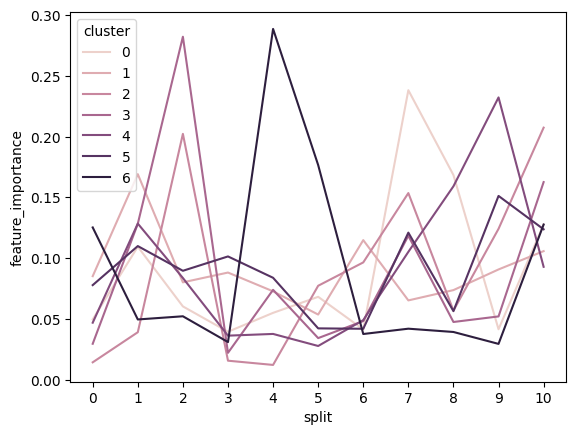

In [59]:
sns.lineplot(x="split", y="feature_importance",
            hue="cluster",
            data=df_importances_rf)

In [61]:
df = pd.merge(df, df_importances_rf, left_on=['cluster', 'split'], right_on=['cluster', 'split'], how='left')

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8085 entries, 0 to 8084
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   athlete             8085 non-null   object 
 1   competition         8085 non-null   object 
 2   heat                8085 non-null   object 
 3   date                8085 non-null   object 
 4   total_time          8085 non-null   float64
 5   lane                8085 non-null   float64
 6   place               8085 non-null   int64  
 7   reaction_time       8085 non-null   object 
 8   total_strides       8085 non-null   float64
 9   hurdle_id           8085 non-null   int64  
 10  hurdle_timing       8085 non-null   float64
 11  interval            8085 non-null   float64
 12  velocity            8085 non-null   float64
 13  strides             8085 non-null   float64
 14  event               8085 non-null   object 
 15  W/M                 8085 non-null   object 
 16  tempor